# Visualising Gaussian Embeddings
Notebook for visualising examples of words embedded as gaussian distributions.

Note: assuming spherical covariance matrices for the moment.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd

## PCA to pre-trained gaussians
Data comes [from here](https://drive.google.com/file/d/1YQQHFV215YjKLlvxpxsKWLm__TlQMw1Q/view) and it must be stored in a folder called **BSG/pretrained_vectors**. 

We'll perform [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to the mean vectors for 2d projection. Then we save them in the same folder.

In [2]:
mu_df = pd.read_csv('BSG/pretrained_vectors/mu.vectors',delimiter=' ', header=None, index_col=0)
mu_df.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
the,-0.146990,-0.131792,-0.053104,0.233861,-0.098344,-0.016384,-0.107202,-0.012970,-0.134497,0.007672,...,-0.156013,-0.046655,-0.135996,0.047934,0.022346,0.126217,0.014250,-0.012605,-0.171871,0.073948
of,0.083906,0.159646,-0.126243,-0.101042,0.100701,0.239031,-0.170803,0.092315,0.092169,0.100025,...,0.004378,0.049943,0.117851,0.062948,-0.165210,0.093388,-0.174594,-0.169171,0.064318,0.039038
and,-0.126295,0.107869,0.239657,-0.346921,0.123882,0.143200,-0.072226,-0.133262,0.000926,-0.081890,...,0.315104,0.008148,0.209700,0.032719,0.019415,-0.376130,-0.160190,-0.042048,-0.095485,-0.049928
to,-0.014846,0.033273,-0.312683,-0.155048,0.353465,0.095302,-0.123623,0.142547,-0.038465,0.067618,...,0.033784,-0.057937,-0.110121,0.222910,-0.153667,-0.037444,-0.143617,0.153703,0.108812,0.217746
in,0.009142,-0.014223,0.114855,-0.232759,0.134076,-0.116560,0.041813,0.051662,-0.098380,-0.221864,...,-0.047316,-0.144986,-0.155159,0.040526,-0.071636,0.012462,-0.043407,-0.175705,-0.057269,-0.120375


In [3]:
pca = PCA(n_components=2)
mu_pca = pca.fit_transform(mu_df)
print(mu_pca.shape)
print(mu_df.shape)
print(type(mu_pca))

mu_pca_df = pd.DataFrame(data=mu_pca, index=mu_df.index)
mu_pca_df.head()

(280003, 2)
(280003, 100)
<class 'numpy.ndarray'>


,0,1
0,,
the,0.240858,-0.091652
of,0.224039,-0.114783
and,0.241038,-0.101011
to,0.262178,-0.088201
in,0.200815,-0.052785


In [4]:
mu_pca_df.to_csv('BSG/pretrained_vectors/mu_pca.vectors',header=False,sep=' ')

**If PCA vectors are already generated then run:**

In [2]:
mu_pca_df = pd.read_csv('BSG/pretrained_vectors/mu_pca.vectors',delimiter=' ', header=None, index_col=0)
#mu_pca_df.head()

In [3]:
def read_vectors_to_dict(mus_file_path, sigmas_file_path, log_sigmas=False, vocab=None, header=False):
    dict = {}
    with open(mus_file_path) as f:
            for i, sentence in enumerate(f):
                if header and i==0:
                    continue

                parts = sentence.strip().split(" ")
                word = parts[0]

                # filter words that are not in vocab
                if vocab is not None and word not in vocab.word_to_index:
                    continue

                mu = np.array(parts[1:], dtype="float32")
                # normalize it
                # mu = mu / (np.sum(mu**2)**0.5)
                dict[word] = [mu]
                # print len(dict)
    with open(sigmas_file_path) as f:
            for i, sentence in enumerate(f):
                if header and i==0:
                    continue

                parts = sentence.strip().split(" ")
                word = parts[0]

                # filter words that are not in vocab
                if vocab is not None and word not in vocab.word_to_index:
                    continue

                sigma = np.array(parts[1:], dtype="float32")
                if log_sigmas:
                    sigma = np.exp(sigma)
                try:
                    dict[word].append(sigma)
                except: #words null and nan are empty in pca file
                    pass
    return dict

In [4]:
mu_path = 'BSG/pretrained_vectors/mu_pca.vectors'
sigma_path = 'BSG/pretrained_vectors/sigma.vectors'
mus_and_sigmas = read_vectors_to_dict(mu_path, sigma_path, log_sigmas=False)
mu_w1, sigma_w1 = mus_and_sigmas['computational']
print('word : computational')
print('mu: '+str(mu_w1))
print('sigma: '+str(sigma_w1))

word : computational
mu: [ 0.16686836 -0.20246866]
sigma: [0.0714027]


**We visualise a single gaussian first**

Adapted from [a scipython blog](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/)

In [5]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

def plot_gaussian_2d_relief(mu,sigma,N=240,z_lim=2,plots_margin=0.85,x_lim=(-3,3),y_lim=(-3,3),fig_size=(9,9)):
    # mu - type: numpy array, corresponds to the centre (after dimensionality reduction)
    # sigma - type: float, the value that goesin the diagonal of the covariance matrix
    # N - type: int, order of the grid. A higher N -> finer grid
    # z_lim - type: float, superior limit of the relief
    # plots_margin 
    # x_lim and y_lim - type: tuple, define the 2d margins
    
    # Our 2-dimensional distribution will be over variables X and Y
    X = np.linspace(-2.5, 2.5, N)
    Y = np.linspace(-2.5, 2.5, N)
    X, Y = np.meshgrid(X, Y)
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    #Computing covariance matrix. Reminder: it is assumed spherical
    Sigma = sigma*np.array([[ 1. , 0.], [0.,  1.]])
    
    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    
    # Create a surface plot and projected filled contour plot under it.
    fig = plt.figure(figsize=fig_size)
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

    cset = ax.contourf(X, Y, Z, zdir='z', offset=-1*plots_margin, cmap=cm.viridis)
    
    # Adjust the limits, ticks and view angle
    ax.set_zlim(-0.05-plots_margin,z_lim)
    ax.set_zticks(np.linspace(0,z_lim,9))
    ax.view_init(14, -21)

    plt.show()

<IPython.core.display.Javascript object>


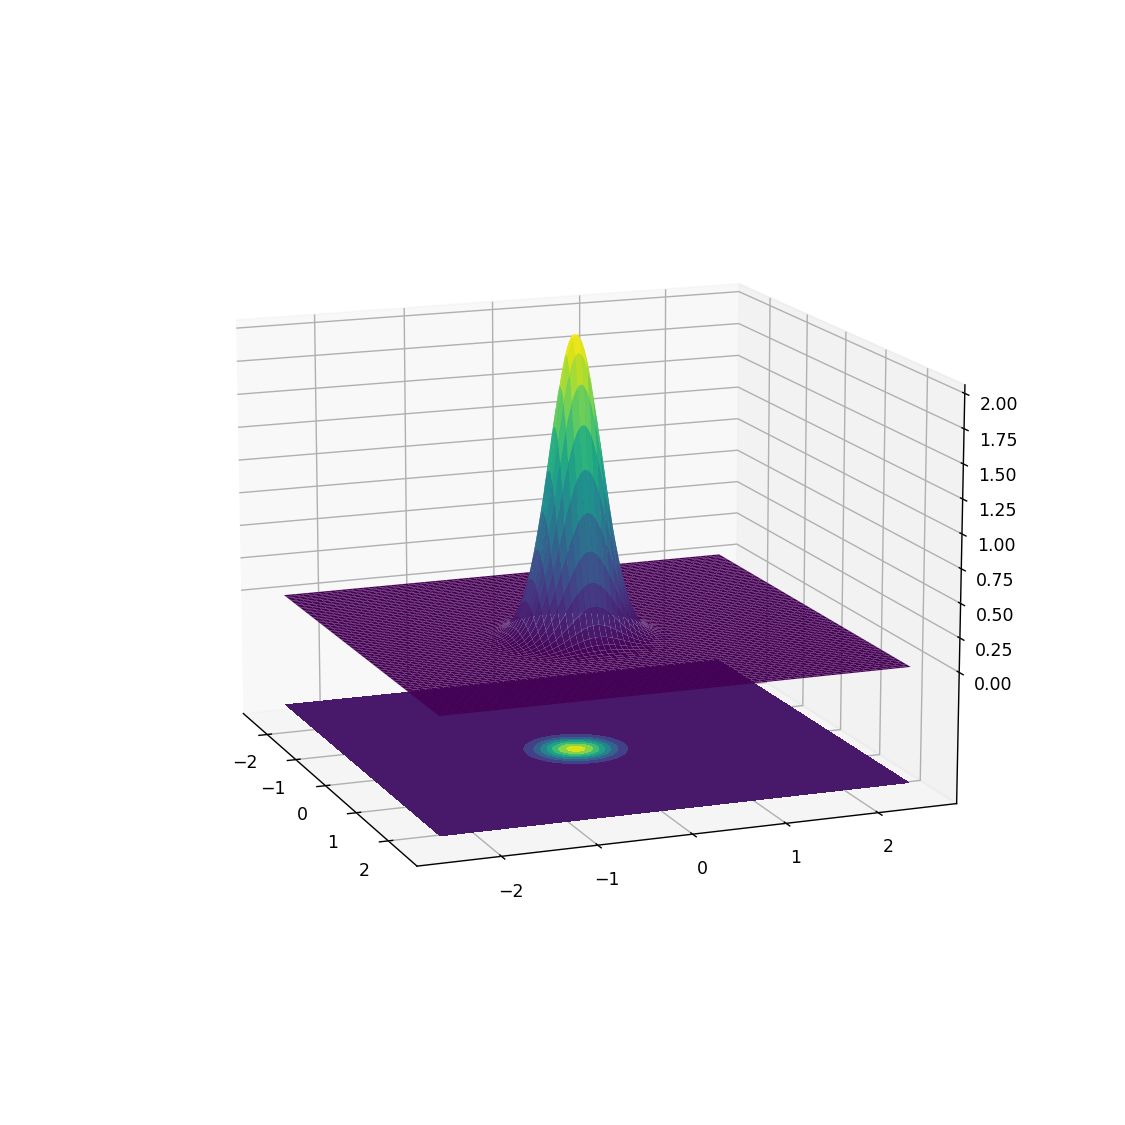

In [6]:
#example
plot_gaussian_2d_relief(mu_w1, sigma_w1)